# FIT3182 Major Assignment Part B Task 2 (Data Visualization)
## George Tan Juan Sheng (30884128)
### 1. Streaming Data Visualization
#### For the incoming climate data plot the line graph of air temperature against arrival time. You need to label some interesting points such as maximum and minimum values.

<IPython.core.display.Javascript object>


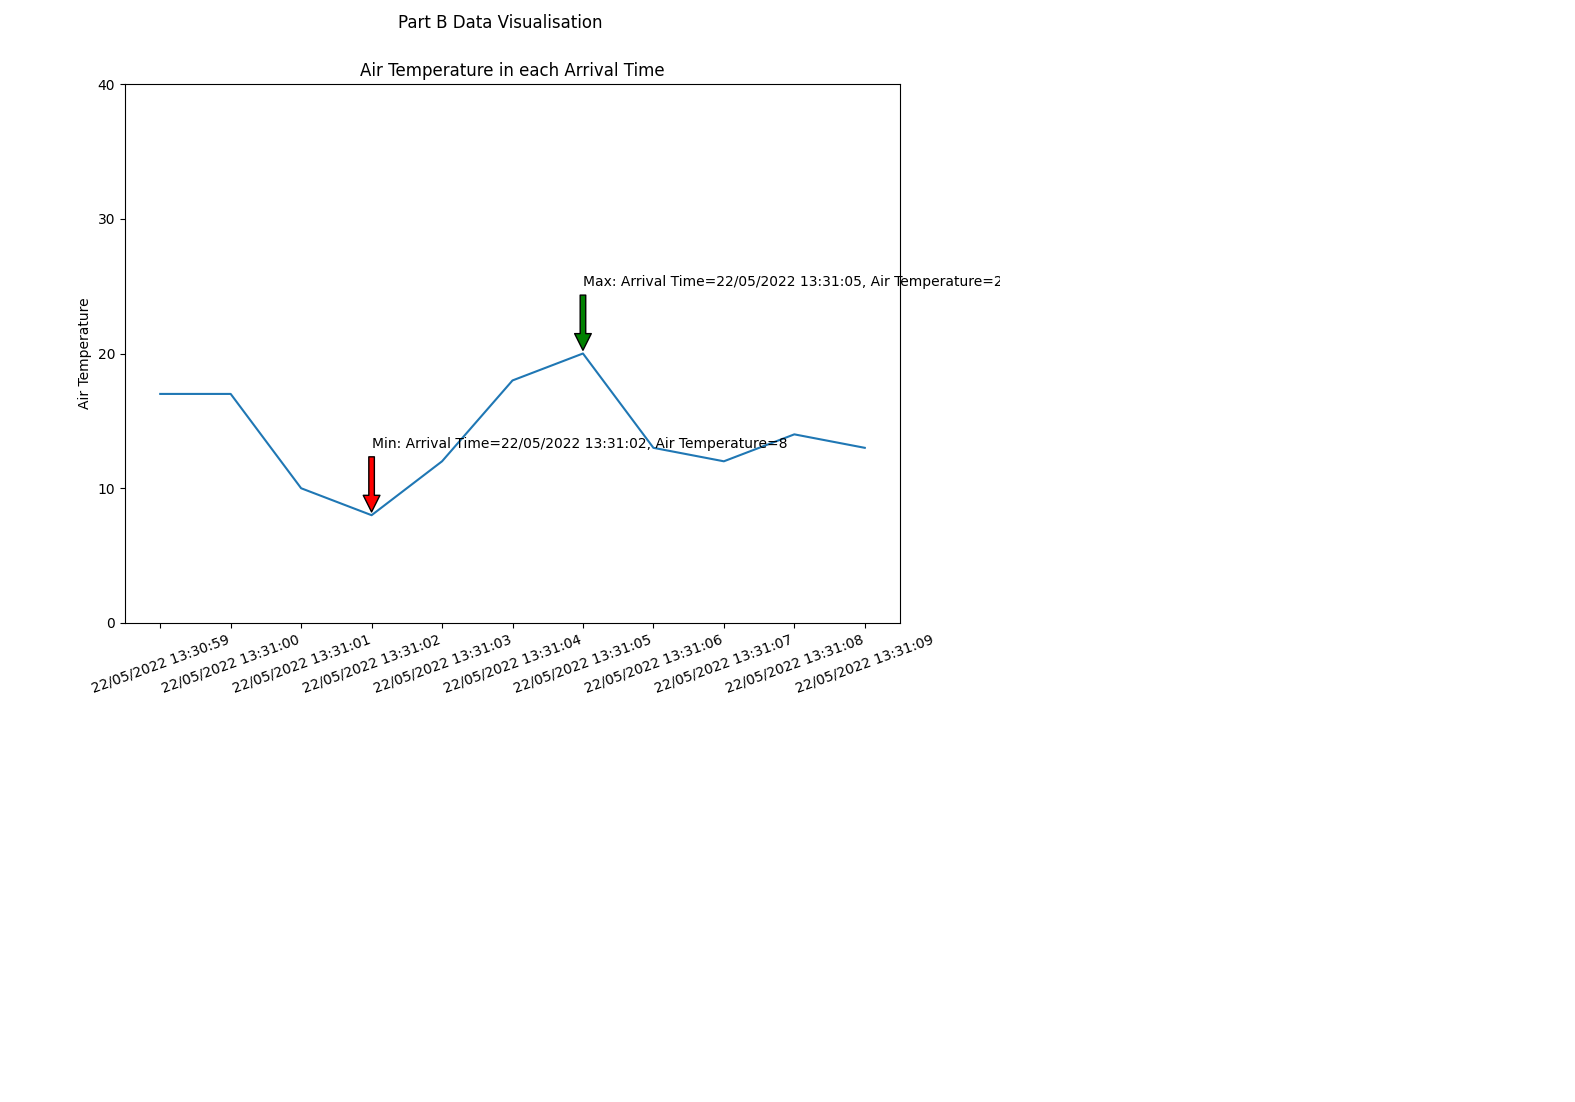

KeyboardInterrupt: 

In [36]:
# import statements
from kafka import KafkaConsumer
from datetime import datetime
from json import loads
import statistics
import matplotlib.pyplot as plt
import statistics
from time import sleep

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'PartB'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Arrival Time={}, Air Temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='green', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Arrival Time={}, Air Temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='red', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   # consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 10
        height = 7
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.5)
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Arrival Time')
        ax1.set_ylabel('Air Temperature')
        fig.suptitle('Part B Data Visualisation') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax1
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax1):
    try:
        # container for x and y values
        x1, y1 = [], []
        check = 0
        firstIteration = True

        for message in consumer:
            
            message = message.value
                
            if message['producer'] == 'climate_streaming':
                x1.append(datetime.now().strftime('%d/%m/%Y %H:%M:%S')) # Get the current time in string format
                y1.append(message['air_temperature_celcius'])
                sleep(1)  #Sleep for one second so that we would not get overlapping date time
                 
            
            # we start plotting only when we have 10 data points
            if len(y1) > 10:
                ax1.clear()
                ax1.plot(x1, y1)
                ax1.set_xlabel('Arrival Time')
                ax1.set_ylabel('Air Temperature')
                ax1.set_title('Air Temperature in each Arrival Time')
                ax1.set_ylim(0,40) 
                ax1.set_yticks([0,10,20,30,40])
                ax1.tick_params(axis='x',labelrotation=20)
                annotate_max(x1, y1, ax1)
                annotate_min(x1, y1, ax1)
                fig.canvas.draw()
                x1.pop(0) # removing the item in the first position
                y1.pop(0)
                
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax1 = init_plots()
    consume_messages(consumer, fig, ax1)
    
    

### 2. Static Data Visualization
#### a. Plot a bar chart to visualize the total number of fire records based on each hour.

<IPython.core.display.Javascript object>


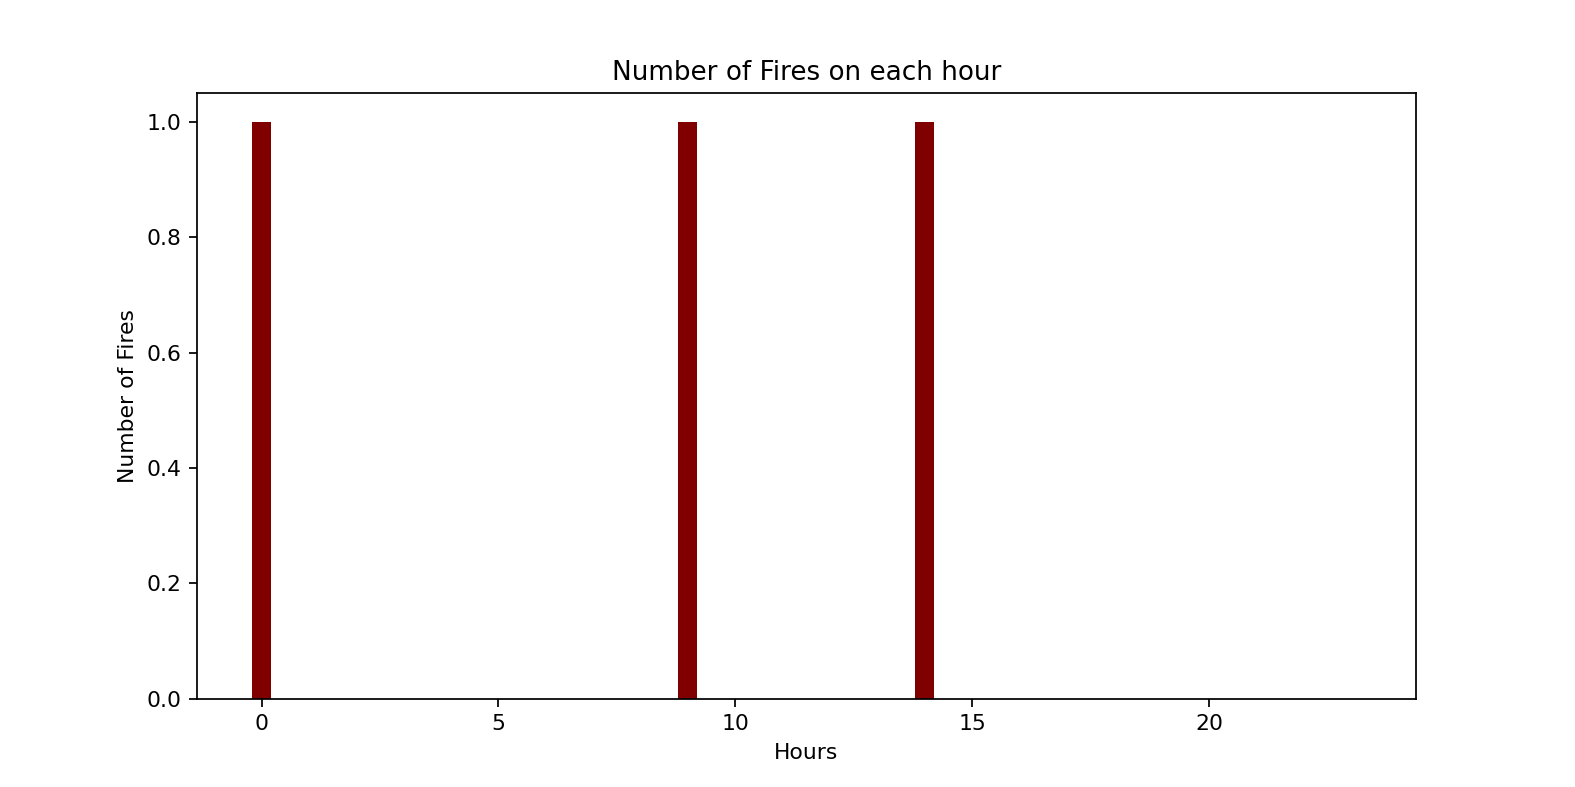

In [37]:
from pprint import pprint
from pymongo import MongoClient
client = MongoClient () 
db = client.fit3182_assignment_db
collection = db.partB

# Unwind the hotspots data, extract the hour from the hotspot's created datetime, group the hours and get the number of fire
cursor = collection.aggregate([
    {"$unwind":"$hotspots"},
    {"$project":{"_id":0,"hour":{"$hour":"$hotspots.datetime"}}},
    {"$group":{"_id":"$hour","numberOfFire":{"$sum":1}}},
    {"$project":{"hour":"$_id","_id":0,"numberOfFire":1}},
    {"$sort":{"hour":1}},
    
])

# Update the number of fire for each hour, ranging from 0 to 23
hour = [i for i in range(24)]
numberOfFire = [0]*24
for document in cursor:
    fireHour = document['hour'] # get the hour
    numberOfFire[fireHour]=document['numberOfFire'] # update the hour's number of fire
    
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(hour, numberOfFire, color ='maroon',
        width = 0.4)
plt.xlabel("Hours")
plt.ylabel("Number of Fires")
plt.title("Number of Fires on each hour")
plt.show()

#### b. In a map visualize fire locations as markers. Use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed information such as air temperature, surface temperature, relative humidity, 5 and confidence with the marker tooltip

In [38]:
from pprint import pprint
from pymongo import MongoClient
import folium

# Create a map based on Victoria's location
victoriaLocation = [-36.9848, 143.3906]
fomap = folium.Map(location=victoriaLocation, zoom_start=6)

# Connect to database's collection
client = MongoClient () 
db = client.fit3182_assignment_db
collection = db.partB

# Get all the fire occurences
cursor = collection.aggregate([
    {"$unwind":"$hotspots"}
])


for document in cursor:
    # Get the necessary detailed information
    location = (document['hotspots']['latitude'],document['hotspots']['longitude'])
    air_temp = document['air_temperature_celcius']
    surface_temp = document['hotspots']['surface_temperature_celcius']
    relative_humidity = document['relative_humidity']
    confidence = document['hotspots']['confidence']
    
    # Prepare the popup detailed information
    fireCause = document['hotspots']['cause']
    detailed_information = f"<ul><li><b>Cause:</b> {fireCause}</li><li><b>Air Temp:</b> {air_temp}</li><li><b>Surface Temp:</b> {surface_temp}</li><li><b>Relative Humidity:</b> {relative_humidity}</li><li><b>Confidence:</b> {confidence}</li></ul>"

    # Add marker according to fire cause
    if fireCause == 'natural':
        folium.Marker(location=location, 
                      popup=folium.Popup(html = detailed_information, max_width = 130),
                      icon=folium.Icon(color="blue", icon="info-sign")).add_to(fomap)
    elif fireCause == 'other':
        folium.Marker(location=location, 
                      popup=folium.Popup(html = detailed_information, max_width = 130),
                      icon=folium.Icon(color="red", icon="info-sign")).add_to(fomap)
        
# Display the map with the markers
fomap